<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [6]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [7]:
import tensorflow_probability as tfp

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [9]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [15]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50'+'_8_fully_connected_large_test'

seed            = 8720

latent_dim      = 8
network_type    = 'fully_connected'

In [16]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [17]:
### load data and join
res_fluxes, res_masks, res_inv_vars = [], [] ,[]
redshifts, SNs, ras, decs, category, sublabel = [], [], [], [], [], []
for nn in range(1,4):
    res_fluxes_, res_masks_, res_inv_vars_ = np.load(os.path.join(root_prepped,'prepped_data_spectra_%s_batch%d.npy'%(label_,nn)))
    redshifts_, SNs_, ras_, decs_, category_, sublabel_ =  np.load(os.path.join(root_prepped,'prepped_data_prop_%s_batch%d.npy'%(label_,nn)))
    if nn==1:
        res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = res_fluxes_, res_masks_, res_inv_vars_, redshifts_, SNs_, ras_, decs_, category_, sublabel_
    else:
        res_fluxes   = np.concatenate([res_fluxes, res_fluxes_],axis=0)
        res_masks    = np.concatenate([res_masks, res_masks_],axis=0)
        res_inv_vars = np.concatenate([res_inv_vars, res_inv_vars_],axis=0)
        redshifts    = np.concatenate([redshifts, redshifts_],axis=0)
        SNs          = np.concatenate([SNs, SNs_],axis=0)
        ras          = np.concatenate([ras, ras_],axis=0)
        decs         = np.concatenate([decs, decs_],axis=0)
        category     = np.concatenate([category, category_],axis=0)
        sublabel     = np.concatenate([sublabel, sublabel_],axis=0)
    

In [18]:
dim = fixed_num_bins

In [19]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask

input        = Input(shape=(dim,1))
input_params = Input(shape=(1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))


if network_type=='fully_connected':
    x = Flatten()(input)
    x = Dense(512)(x)
    x = BatchNormalization(trainable=False)(x)
    x = Dense(128)(x)
    x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(16)(x)
    x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(latent_dim)(x)  
    #x = tf.concat([x,input_params],axis=1)
    #z = Flatten()(input_params)
    #x = tf.concat([input_params,x], axis=1)
    x = Dense(16)(x)
    x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization(trainable=False)(x)
    x = LeakyReLU()(x)
    x = Dense(512)(x)
    x = BatchNormalization(trainable=False)(x)
    x = Dense(dim)(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(256, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(256, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    #x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    x = LeakyReLU()(x)
    #x = tf.concat([z,input_params], axis=1)
    x = Dense(1024,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((32,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    #x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0][0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}
    
    


In [20]:
tf.random.set_seed(seed)


lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=[],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1000)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 512)          512512      flatten_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 512)          2048        dense_10[0][0]                   
_______________________________________________________________________________________

In [21]:
def make_scheduler(length, initial_lr,factor=1.2):
    
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
        
    return scheduler



In [22]:

DATASET_SIZE = len(res_fluxes)
train_size   = int(0.7* DATASET_SIZE)
test_size    = int(0.1 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)
indices      = np.arange(DATASET_SIZE)

In [23]:
np.random.seed(seed)
np.random.shuffle(indices)

In [24]:
def reshuffle(list_, indices):
    res = []
    for item_ in list_:
        res.append(item_[indices])
    return res

In [25]:
res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = reshuffle([res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel], indices)

In [26]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    z_array = np.asarray(z_array, dtype=np.float32)
    indx = np.where((z_array>min_z)*(z_array<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = redshift_bin(.1, .4, redshifts, [res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel])

new datasize:  218411


In [27]:
mean=np.mean(res_fluxes)
print(mean)

239580.16070643716


In [28]:
train_data   = np.expand_dims(res_fluxes[:train_size],-1)/mean
valid_data   = np.expand_dims(res_fluxes[train_size:train_size+valid_size],-1)/mean
test_data    = np.expand_dims(res_fluxes[-test_size::],-1)/mean

train_mask   = np.expand_dims(res_masks[:train_size],-1)
valid_mask   = np.expand_dims(res_masks[train_size:train_size+valid_size],-1)
test_mask    = np.expand_dims(res_masks[-test_size::],-1)

train_noise  = np.expand_dims(res_inv_vars[:train_size],-1)*mean**2
valid_noise  = np.expand_dims(res_inv_vars[train_size:train_size+valid_size],-1)*mean**2
test_noise   = np.expand_dims(res_inv_vars[-test_size::],-1)*mean**2

train_params = np.asarray(redshifts, dtype=np.float32)[:train_size]
valid_params = np.asarray(redshifts, dtype=np.float32)[train_size:train_size+valid_size]
test_params = np.asarray(redshifts, dtype=np.float32)[-test_size::]

train_ras = np.asarray(ras, dtype=np.float32)[:train_size]
valid_ras = np.asarray(ras, dtype=np.float32)[train_size:train_size+valid_size]
test_ras = np.asarray(ras, dtype=np.float32)[-test_size::]

train_decs = np.asarray(decs, dtype=np.float32)[:train_size]
valid_decs = np.asarray(decs, dtype=np.float32)[train_size:train_size+valid_size]
test_decs = np.asarray(decs, dtype=np.float32)[-test_size::]

train_cat = category[:train_size]
valid_cat = category[train_size:train_size+valid_size]
test_cat = category[-test_size::]

train_labels = sublabel[:train_size]
valid_labels = sublabel[train_size:train_size+valid_size]
test_labels = sublabel[-test_size::]

In [29]:
len(train_data)

164965

In [30]:
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback])
    return history

In [31]:
def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [32]:
histories =[]
for batchsize, nepochs, lr_ann in zip([32,64,256],[20,20,15],[15,15,8]):
    histories.append(training_cycle(batchsize, nepochs, lr_ann, 1e-3, 1.))
    res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_params))
    print(custom_metric((valid_data,valid_mask,valid_noise, valid_params),res_valid))
    res_train = lstm_ae.predict((train_data[:len(valid_data)],train_mask[:len(valid_data)],train_noise[:len(valid_data)], train_params[:len(valid_data)]))
    print(custom_metric((train_data[:len(valid_data)],train_mask[:len(valid_data)],train_noise[:len(valid_data)], train_params[:len(valid_data)]),res_train))

Epoch 1/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 4.8595 - lr: 0.0010
Epoch 2/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 100.7715 - lr: 0.0010
Epoch 3/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 2.8616 - lr: 0.0010
Epoch 4/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 8.3661 - lr: 0.0010
Epoch 5/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 3.2823 - lr: 0.0010
Epoch 6/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 2.6933 - lr: 0.0010
Epoch 7/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 3.5137 - lr: 0.0010
Epoch 8/20
5156/5156 [==============================] - 11s 2ms/step - training_loss: 2.3976 - lr: 0.0010
Epoch 9/20
5156/5156 [==============================] - 12s 2ms/step - training_loss: 2.4291 - lr: 0.0010
Epoch 10/20
5156/5156 [=====================

In [33]:
res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_params))

In [34]:
custom_metric((valid_data,valid_mask,valid_noise, valid_params),res_valid)

1.3147292034165092

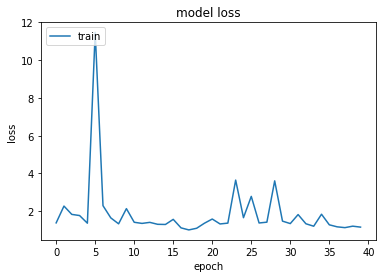

In [35]:
plt.plot(np.append(histories[0].history['training_loss'],histories[1].history['training_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(curr_layer)
        new_model.add(curr_layer)
    return new_model

In [37]:
encoder = extract_layers(lstm_ae,1,14)

decoder = extract_layers(lstm_ae,14,26)

In [38]:
encoder.build((None,fixed_num_bins))
decoder.build((None,latent_dim))

In [39]:
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               512512    
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8

In [40]:
encoded_valid = encoder.predict(valid_data)
encoded_train = encoder.predict(train_data)
encoded_test = encoder.predict(test_data)

In [41]:
decoded_valid = decoder.predict(encoded_valid)
decoded_train = decoder.predict(encoded_train)
decoded_test = decoder.predict(encoded_test)

In [42]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder.save(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder.save(path)
print(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_8_fully_connected_large_test/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_8_fully_connected_large_test/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_8_fully_connected_large_test


In [43]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder = tf.keras.models.load_model(path)

In [44]:
np.save(os.path.join(root_encoded,'encoded_%s.npy'%label_2),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)

In [45]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test])

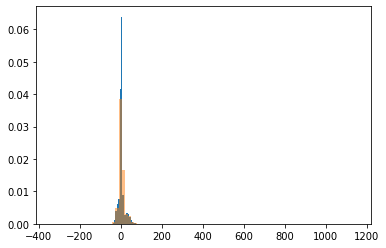

In [46]:
_=plt.hist(encoded_valid.flatten(),bins=100,density=True)
_=plt.hist(encoded_train.flatten(),bins=100,density=True, alpha=0.5)

In [47]:
len(encoded_valid)

47133

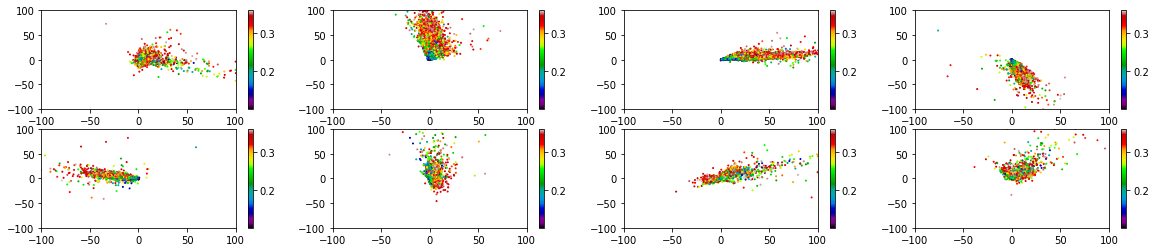

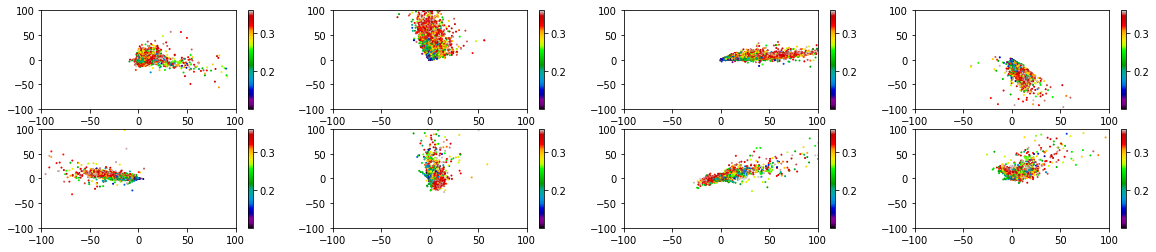

In [49]:
fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_params, cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-100,100)
    ax[ii].set_ylim(-100,100)
plt.show()

fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:47000,ii],encoded_train[:47000,jj],c=train_params[:47000], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-100,100)
    ax[ii].set_ylim(-100,100)
plt.show()

In [50]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(sublabel)
print(le.classes_, le.transform(le.classes_))

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


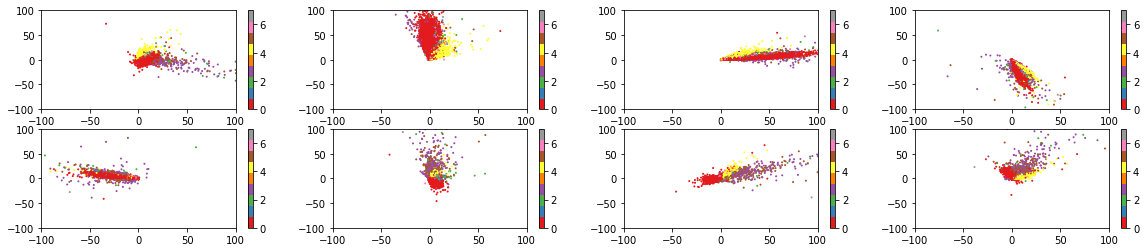

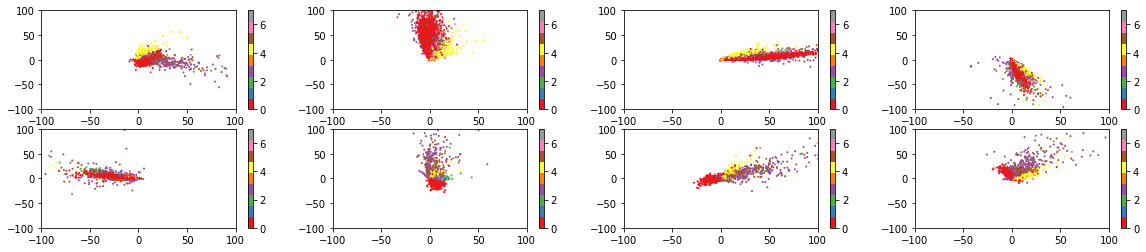

In [51]:
fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=le.transform(valid_labels), cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-100,100)
    ax[ii].set_ylim(-100,100)
plt.show()

fig, ax = plt.subplots(2,4, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:47000,ii],encoded_train[:47000,jj],c=le.transform(train_labels)[:47000], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-100,100)
    ax[ii].set_ylim(-100,100)
plt.show()

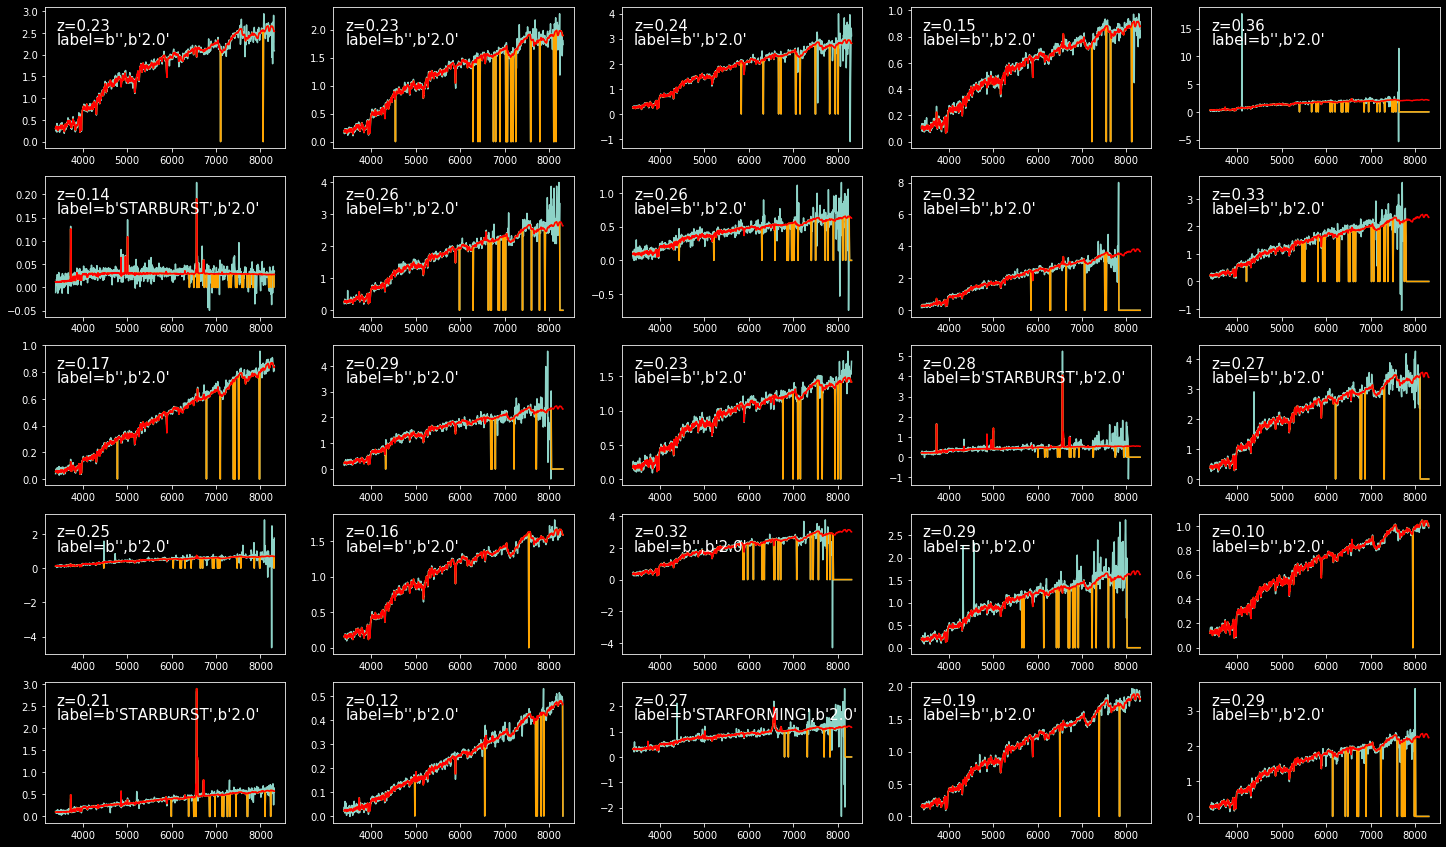

In [52]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_valid)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_valid)[ii], color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid_labels[ii],valid_cat[ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

In [53]:
enc = encoder.predict(train_data)

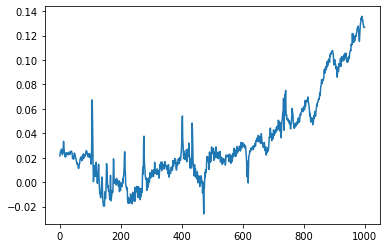

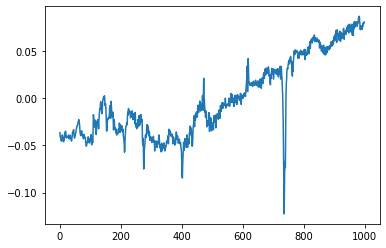

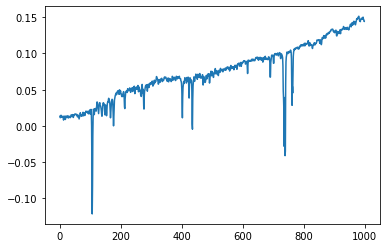

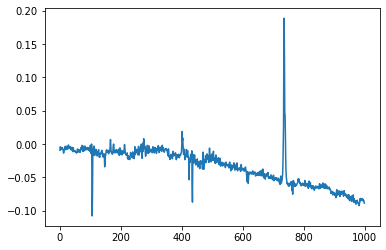

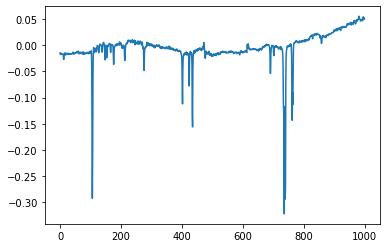

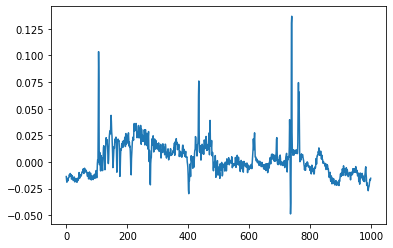

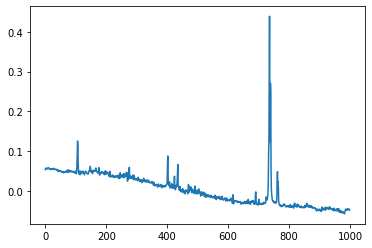

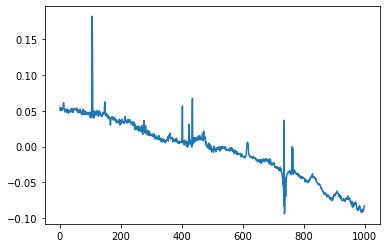

In [54]:
sens=[]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]+=1
    sens+=[res]
for ii in range(latent_dim):
    res = np.mean(enc,axis=0)
    res[ii]-=1
    sens+=[res]
sens+=[np.mean(enc,axis=0)]
sens = np.asarray(sens)
test = decoder.predict(sens)

for ii in range(8):
    plt.plot(test[ii]-test[8+ii])
    plt.show()